# Delivery Route Optimization using Reinforcement Learning and AI Assistance

## Overview
This notebook demonstrates how to optimize delivery routes using various reinforcement learning algorithms (Q-Learning, SARSA, DQN) with the assistance of a Google Gemini AI model for generating locations and hyperparameter tuning recommendations. The environment simulates a delivery scenario in a specified city using OpenStreetMap (OSM) data.

### Import Required Libraries and Modules

In [29]:
import json

import folium
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
from IPython.display import display, Markdown, HTML

try:
    import osmnx as ox
    import networkx as nx

    OSMNX_AVAILABLE = True
except ImportError:
    OSMNX_AVAILABLE = False

from dqn import DQNAgent
from environment import DeliveryEnvironment
from google_LLM import GoogleAIModelExplainer
from osm_client import OSMClient
from q_learning import QLearningAgent
from sarsa import SarsaAgent

print("All libraries imported successfully!")
if not OSMNX_AVAILABLE:
    print("Warning: OSMnx not available. Network-based routing will be disabled.")

All libraries imported successfully!


### Visualization Functions

In [30]:
def plot_osmnx_route(graph, route_nodes, file_path="osmnx_route.png"):
    """
    Plots the delivery route on the OSMnx street graph.
    """
    if not OSMNX_AVAILABLE:
        print("Cannot plot OSMnx route: osmnx is not installed.")
        return None

    full_route = []
    for i in range(len(route_nodes) - 1):
        try:
            path_segment = nx.shortest_path(graph, route_nodes[i], route_nodes[i + 1], weight='length')
            full_route.extend(path_segment[1:])
        except nx.NetworkXNoPath:
            print(f"Warning: No path found between node {route_nodes[i]} and {route_nodes[i + 1]}")
            continue

    if route_nodes:
        full_route.insert(0, route_nodes[0])

    if not full_route:
        print("Cannot plot route: The calculated route is empty or invalid.")
        return None

    fig, ax = ox.plot_graph_route(
        graph, full_route, show=False, close=False,
        route_color='r', route_linewidth=4, node_size=0,
        filepath=file_path, dpi=300, save=True
    )
    print(f"OSMnx route map saved to {file_path}")
    plt.close(fig)

    # Display inline
    fig, ax = plt.subplots(figsize=(12, 8))
    ox.plot_graph_route(graph, full_route, route_color='r', route_linewidth=4, node_size=0, ax=ax)
    ax.set_title("Delivery Route on Street Network", fontsize=14)
    plt.tight_layout()
    plt.show()

    return fig


def plot_learning_curves(reward_histories, title="RL Agent Learning Curves"):
    """Plots learning curves for multiple reinforcement learning agents."""
    plt.figure(figsize=(12, 8))

    colors = ['blue', 'green', 'red', 'orange', 'purple']
    for idx, (agent_name, rewards) in enumerate(reward_histories.items()):
        color = colors[idx % len(colors)]

        # Plot raw rewards with transparency
        plt.plot(rewards, alpha=0.15, color=color, linewidth=0.5)

        # Plot moving average
        window_size = min(100, len(rewards) // 10)
        if len(rewards) >= window_size:
            moving_avg = np.convolve(rewards, np.ones(window_size) / window_size, mode='valid')
            plt.plot(range(window_size - 1, len(rewards)), moving_avg,
                     label=f'{agent_name}', color=color, linewidth=2)

    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel("Episodes", fontsize=14)
    plt.ylabel("Total Reward", fontsize=14)
    plt.legend(fontsize=12, loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.savefig("learning_curves.png", dpi=150, bbox_inches='tight')
    plt.show()


def plot_tuning_impact(initial_histories, optimized_histories):
    """Plots learning curves before and after hyperparameter tuning."""
    agents = list(initial_histories.keys())
    num_agents = len(agents)

    fig, axes = plt.subplots(num_agents, 1, figsize=(14, 5 * num_agents))
    if num_agents == 1:
        axes = [axes]

    colors = ['red', 'blue', 'green']

    for idx, (agent_name, ax) in enumerate(zip(agents, axes)):
        color = colors[idx % len(colors)]

        # Plot initial training
        initial_rewards = initial_histories.get(agent_name, [])
        window_size = max(1, len(initial_rewards) // 20)
        if len(initial_rewards) >= window_size:
            initial_avg = np.convolve(initial_rewards, np.ones(window_size) / window_size, mode='valid')
            ax.plot(range(window_size - 1, len(initial_rewards)), initial_avg,
                    label='Before Tuning', color=color, linestyle='--', alpha=0.7)

        # Plot optimized training
        opt_rewards = optimized_histories.get(agent_name, [])
        window_size = max(1, len(opt_rewards) // 20)
        if len(opt_rewards) >= window_size:
            opt_avg = np.convolve(opt_rewards, np.ones(window_size) / window_size, mode='valid')
            ax.plot(range(window_size - 1, len(opt_rewards)), opt_avg,
                    label='After Tuning', color=color, linewidth=2)

        ax.set_title(f"Hyperparameter Tuning Impact: {agent_name}", fontsize=14, fontweight='bold')
        ax.set_xlabel("Episodes", fontsize=12)
        ax.set_ylabel("Total Reward", fontsize=12)
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("tuning_impact.png", dpi=150, bbox_inches='tight')
    plt.show()


def plot_delivery_route(locations, route, addresses=None, file_path="delivery_route.html"):
    """Creates an interactive Folium map of the delivery route."""
    if locations.size == 0:
        print("Cannot plot route: No locations provided.")
        return None

    map_center = np.mean(locations, axis=0)
    m = folium.Map(location=map_center, zoom_start=13)

    # Add depot marker
    folium.Marker(
        location=locations[0],
        popup=f"Depot (Location 0)",
        tooltip="DEPOT",
        icon=folium.Icon(color="red", icon="warehouse", prefix="fa"),
    ).add_to(m)

    # Add delivery locations
    for i, loc in enumerate(locations[1:], 1):
        address = addresses[i] if addresses else f"Location {i}"
        folium.Marker(
            location=loc,
            popup=f"Delivery {i}: {address}",
            tooltip=f"Stop {i}",
            icon=folium.Icon(color="blue", icon="package", prefix="fa"),
        ).add_to(m)

    # Add route polyline
    if route:
        route_coords = [locations[i] for i in route]
        folium.PolyLine(
            route_coords,
            color="green",
            weight=3.5,
            opacity=0.8,
            popup="Optimized Delivery Route"
        ).add_to(m)

    # Add route distance display
    total_distance = 0
    for i in range(len(route) - 1):
        start = locations[route[i]]
        end = locations[route[i + 1]]
        total_distance += np.sqrt((end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2) * 111  # Approx km

    distance_html = f"""
    <div style="position: fixed; bottom: 50px; left: 50px; width: 250px; height: 70px;
                background-color: white; border:2px solid grey; z-index:9999; font-size:14px;
                padding:10px; border-radius:5px;">
    <b>Route Summary:</b><br>
    • Total Stops: {len(route) - 1}<br>
    • Estimated Distance: {total_distance:.1f} km
    </div>
    """
    m.get_root().html.add_child(folium.Element(distance_html))

    m.save(file_path)
    print(f"Interactive route map saved to {file_path}")

    # Display in notebook
    display(HTML(f'<h4>Interactive Route Map</h4>'))
    display(HTML(f'<p>Map saved to: <code>{file_path}</code></p>'))

    return m


def plot_comparison(results, title="Algorithm Performance Comparison"):
    """Creates comparison bar charts for different algorithms."""
    labels = list(results.keys())
    if not labels:
        return

    metrics = list(results[labels[0]].keys())
    num_metrics = len(metrics)

    fig, axes = plt.subplots(num_metrics, 1, figsize=(12, 5 * num_metrics))
    if num_metrics == 1:
        axes = [axes]

    colors = plt.cm.Set3(np.linspace(0, 1, len(labels)))

    for i, (metric, ax) in enumerate(zip(metrics, axes)):
        metric_values = []
        metric_errors = []

        for label in labels:
            value = results[label].get(metric, 0)
            if isinstance(value, (list, tuple)):
                metric_values.append(np.mean(value))
                metric_errors.append(np.std(value))
            else:
                metric_values.append(value)
                metric_errors.append(0)

        bars = ax.bar(labels, metric_values, color=colors, edgecolor='black', linewidth=1.2)

        # Add value labels on top of bars
        for bar, value in zip(bars, metric_values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2., height + 0.01,
                    f'{value:.2f}', ha='center', va='bottom', fontsize=10)

        metric_title = metric.replace('_', ' ').title()
        ax.set_ylabel(metric_title, fontsize=12)
        ax.set_title(f"{metric_title} Comparison", fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')

        # Rotate x-axis labels if needed
        plt.setp(ax.get_xticklabels(), rotation=15, ha='right')

    plt.tight_layout()
    plt.savefig("algorithm_comparison.png", dpi=150, bbox_inches='tight')
    plt.show()


def plot_route_progression(locations, route):
    """Shows the progression of the route with step-by-step visualization."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    route_coords = [locations[i] for i in route]
    route_coords = np.array(route_coords)

    # Plot 1: Complete route
    axes[0].scatter(route_coords[:, 1], route_coords[:, 0], c='blue', s=50, alpha=0.6)
    axes[0].plot(route_coords[:, 1], route_coords[:, 0], 'g-', linewidth=2, alpha=0.8)
    axes[0].scatter(route_coords[0, 1], route_coords[0, 0], c='red', s=200, marker='*', label='Depot')
    axes[0].set_title("Complete Optimized Route", fontsize=12, fontweight='bold')
    axes[0].set_xlabel("Longitude")
    axes[0].set_ylabel("Latitude")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Step distances
    distances = []
    for i in range(len(route_coords) - 1):
        dist = np.sqrt((route_coords[i + 1, 0] - route_coords[i, 0]) ** 2 +
                       (route_coords[i + 1, 1] - route_coords[i, 1]) ** 2) * 111  # Convert to km
        distances.append(dist)

    axes[1].bar(range(1, len(distances) + 1), distances, color='skyblue', edgecolor='black')
    axes[1].set_title("Distance per Route Segment", fontsize=12, fontweight='bold')
    axes[1].set_xlabel("Route Segment")
    axes[1].set_ylabel("Distance (km)")
    axes[1].grid(True, alpha=0.3, axis='y')

    # Plot 3: Cumulative distance
    cumulative_dist = np.cumsum(distances)
    axes[2].plot(range(1, len(cumulative_dist) + 1), cumulative_dist, 'b-o', linewidth=2, markersize=6)
    axes[2].set_title("Cumulative Distance", fontsize=12, fontweight='bold')
    axes[2].set_xlabel("Step")
    axes[2].set_ylabel("Cumulative Distance (km)")
    axes[2].grid(True, alpha=0.3)

    # Plot 4: Route statistics
    axes[3].axis('off')
    stats_text = f"""
    Route Statistics:
    • Total Locations: {len(route)}
    • Total Distance: {cumulative_dist[-1]:.2f} km
    • Avg. Segment Distance: {np.mean(distances):.2f} km
    • Longest Segment: {np.max(distances):.2f} km
    • Shortest Segment: {np.min(distances):.2f} km
    • Return to Depot: {'Yes' if route[-1] == route[0] else 'No'}
    """
    axes[3].text(0.1, 0.5, stats_text, fontsize=12, family='monospace',
                 bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.7))

    plt.suptitle("Route Analysis", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig("route_progression.png", dpi=150, bbox_inches='tight')
    plt.show()

### Helper function - Generate random locations

In [31]:
def generate_random_locations(city_name, num_locations):
    """
    Generates random coordinates within a given city's bounding box using OSM.
    """
    print(f"Generating random 'live' locations in {city_name}...")
    osm = OSMClient()
    bbox = osm.get_bounding_box(city_name)
    if not bbox:
        print(f"Could not find bounding box for {city_name}. Exiting.")
        return None

    min_lat, max_lat, min_lon, max_lon = bbox
    lats = np.random.uniform(min_lat, max_lat, num_locations)
    lons = np.random.uniform(min_lon, max_lon, num_locations)

    locations = np.vstack((lats, lons)).T
    print(f"Generated {num_locations} random locations in {city_name}.")
    return locations


def train_agent(agent, env, num_episodes, is_dqn=False):
    """A unified training function for all agent types."""
    reward_history = []
    episode_rewards = []

    for episode in range(num_episodes):
        state = env.reset(vectorized=is_dqn)
        done = False
        total_reward = 0
        step_count = 0

        action = agent.choose_action(state, env.get_possible_actions())

        while not done and step_count < 100:  # Prevent infinite loops
            if action is None:
                break

            next_state_tuple, reward, done = env.step(action)

            if is_dqn:
                next_state = env._get_state(vectorized=True)
                agent.add_experience(state, action, reward, next_state, done)
                agent.update_model()
            else:
                next_state = next_state_tuple
                next_possible_actions = env.get_possible_actions()
                if isinstance(agent, SarsaAgent):
                    next_action = agent.choose_action(next_state, next_possible_actions)
                    agent.update_q_table(state, action, reward, next_state, next_action)
                    action = next_action
                else:  # Q-Learning
                    agent.update_q_table(state, action, reward, next_state, next_possible_actions)

            if not isinstance(agent, SarsaAgent):
                action = agent.choose_action(next_state, env.get_possible_actions())

            state = next_state
            total_reward += reward
            step_count += 1

        agent.decay_epsilon()
        reward_history.append(total_reward)
        episode_rewards.append(total_reward)

        # Progress indicator
        if (episode + 1) % max(1, num_episodes // 10) == 0:
            print(f"  Episode {episode + 1}/{num_episodes}: "
                  f"Reward = {total_reward:.1f}, "
                  f"ε = {agent.epsilon:.3f}")

    return reward_history


def evaluate_agent(agent, env, is_dqn=False):
    """Evaluates the agent's performance and returns the route."""
    state = env.reset(vectorized=is_dqn)
    route = [env.start_pos_index]
    total_distance = 0
    step_limit = env.num_locations * 2  # Prevent infinite loops

    for step in range(step_limit):
        possible_actions = env.get_possible_actions()
        if not possible_actions:
            break

        # Temporarily disable exploration for evaluation
        original_epsilon = agent.epsilon
        agent.epsilon = 0.0

        action = agent.choose_action(state, possible_actions)

        agent.epsilon = original_epsilon

        if action is None or action in route[1:]:  # Avoid revisiting
            break

        distance = env.distance_matrix[env.current_pos_index][action]
        total_distance += distance
        route.append(action)

        state, _, done = env.step(action)
        if is_dqn:
            state = env._get_state(vectorized=True)

        if done or len(route) > env.num_locations:
            break

    # Return to depot if not already there
    if route[-1] != env.start_pos_index:
        total_distance += env.distance_matrix[route[-1]][env.start_pos_index]
        route.append(env.start_pos_index)

    return route, total_distance / 1000  # Convert to km

### Main Execution - Configuration

In [32]:
# --- CONFIGURATION ---
CITY = "Middlesbrough"
NUM_PARCELS = 50  # Reduced for faster demonstration
DISTANCE_METRIC = 'network'  # 'network' or 'haversine'
NUM_EPISODES_TUNE = 300
NUM_EPISODES_FINAL = 1000
load_dotenv()

print(f"""
Delivery Route Optimization Configuration:
-----------------------------------------
City: {CITY}
Number of Parcels: {NUM_PARCELS}
Distance Metric: {DISTANCE_METRIC}
Tuning Episodes: {NUM_EPISODES_TUNE}
Final Training Episodes: {NUM_EPISODES_FINAL}
""")


Delivery Route Optimization Configuration:
-----------------------------------------
City: Middlesbrough
Number of Parcels: 50
Distance Metric: network
Tuning Episodes: 300
Final Training Episodes: 1000



### Main Execution

In [33]:
# --- 1. INITIALIZE AI & LOCATIONS ---
explainer = GoogleAIModelExplainer()
locations_list = None

if not explainer.available:
    print(f"Using Gemini to generate {NUM_PARCELS + 1} locations in {CITY}...")
    locations_list = explainer.generate_locations_for_city(CITY, NUM_PARCELS + 1)

if locations_list:
    print(f"Successfully generated {len(locations_list)} locations using AI.")
    env = DeliveryEnvironment(addresses=locations_list, city_name=CITY, distance_metric=DISTANCE_METRIC)
else:
    print("AI unavailable. Generating random locations...")
    locations_coords = generate_random_locations(CITY, NUM_PARCELS + 1)
    if locations_coords is None:
        print("Failed to generate locations. Exiting.")
    else:
        env = DeliveryEnvironment(locations=locations_coords, city_name=CITY, distance_metric=DISTANCE_METRIC)

print(f"\nEnvironment initialized with {env.num_locations} locations")
print(f"Distance matrix shape: {env.distance_matrix.shape}")

AI unavailable. Generating random locations...
Generating random 'live' locations in Middlesbrough...
Generated 51 random locations in Middlesbrough.
Graph downloaded.
Calculating network distance matrix (this may take a while)...

Environment initialized with 51 locations
Distance matrix shape: (51, 51)


In [43]:
print(env.addresses)
print(env.locations)
print(env.nodes)

['Location 0', 'Location 1', 'Location 2', 'Location 3', 'Location 4', 'Location 5', 'Location 6', 'Location 7', 'Location 8', 'Location 9', 'Location 10', 'Location 11', 'Location 12', 'Location 13', 'Location 14', 'Location 15', 'Location 16', 'Location 17', 'Location 18', 'Location 19', 'Location 20', 'Location 21', 'Location 22', 'Location 23', 'Location 24', 'Location 25', 'Location 26', 'Location 27', 'Location 28', 'Location 29', 'Location 30', 'Location 31', 'Location 32', 'Location 33', 'Location 34', 'Location 35', 'Location 36', 'Location 37', 'Location 38', 'Location 39', 'Location 40', 'Location 41', 'Location 42', 'Location 43', 'Location 44', 'Location 45', 'Location 46', 'Location 47', 'Location 48', 'Location 49', 'Location 50']
[[54.52823932 -1.2745399 ]
 [54.51327535 -1.23574497]
 [54.58949094 -1.25545257]
 [54.52470892 -1.17681448]
 [54.53473013 -1.25166222]
 [54.52906534 -1.19396154]
 [54.54427404 -1.24602815]
 [54.53777411 -1.24389171]
 [54.57915899 -1.16280612]
 

### Create agent Objects

In [35]:
# Initialize reinforcement learning agents
agents = {
    "Q-Learning": QLearningAgent(
        action_space=list(range(env.num_locations)),
        epsilon=1.0,
        epsilon_decay=0.995,
        alpha=0.1,
        gamma=0.9
    ),
    "SARSA": SarsaAgent(
        action_space=list(range(env.num_locations)),
        epsilon=1.0,
        epsilon_decay=0.995,
        alpha=0.1,
        gamma=0.9
    ),
    "DQN": DQNAgent(
        state_size=env.get_state_size(),
        action_size=env.num_locations,
        epsilon=1.0,
        epsilon_decay=0.995,
        learning_rate=0.001
    )
}

print("Agents initialized:")
for name, agent in agents.items():
    print(f"  {name}: ε={agent.epsilon:.2f}")

Agents initialized:
  Q-Learning: ε=1.00
  SARSA: ε=1.00
  DQN: ε=1.00



INITIAL TRAINING & HYPERPARAMETER TUNING

Training Q-Learning for hyperparameter tuning...
  Episode 30/300: Reward = -310106.0, ε = 0.860
  Episode 60/300: Reward = -269509.4, ε = 0.740
  Episode 90/300: Reward = -288161.3, ε = 0.637
  Episode 120/300: Reward = -299080.6, ε = 0.548
  Episode 150/300: Reward = -299020.4, ε = 0.471
  Episode 180/300: Reward = -253964.4, ε = 0.406
  Episode 210/300: Reward = -281574.3, ε = 0.349
  Episode 240/300: Reward = -282330.6, ε = 0.300
  Episode 270/300: Reward = -246397.6, ε = 0.258
  Episode 300/300: Reward = -294484.3, ε = 0.222
  Final 100-episode average reward: -283327.45
  Asking Gemini for hyperparameter recommendations for Q-Learning...
  ✗ Could not get AI recommendations for Q-Learning.

Training SARSA for hyperparameter tuning...
  Episode 30/300: Reward = -300784.9, ε = 0.860
  Episode 60/300: Reward = -313700.9, ε = 0.740
  Episode 90/300: Reward = -291905.7, ε = 0.637
  Episode 120/300: Reward = -267994.9, ε = 0.548
  Episode 150/

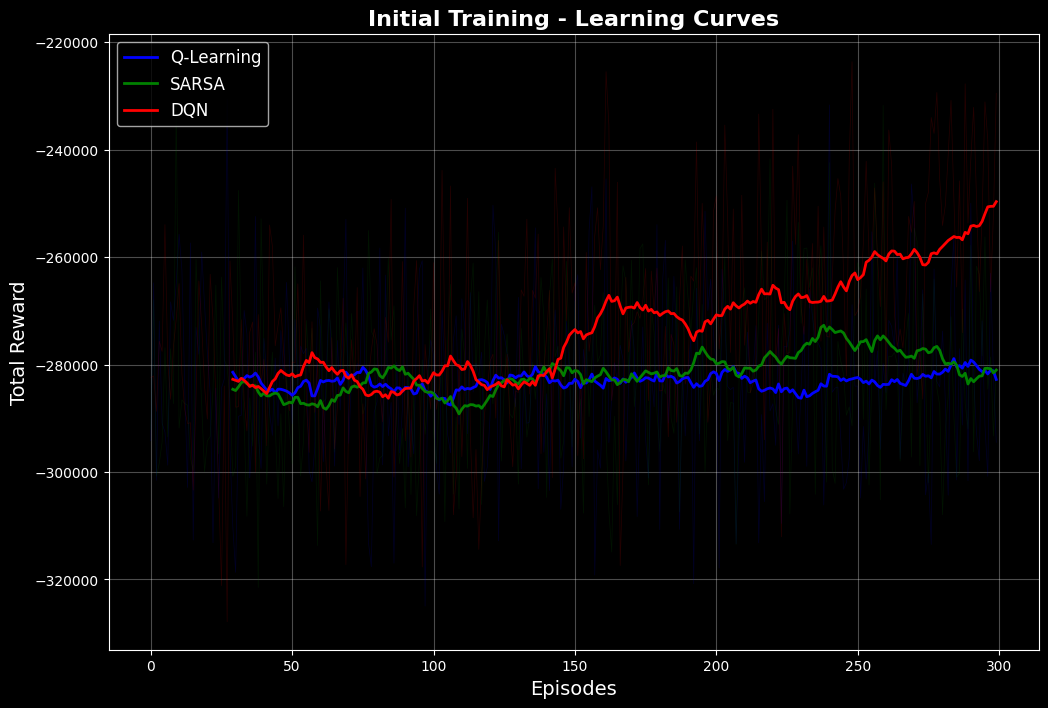

In [36]:
# --- 2. INITIAL TRAINING & AI-TUNING ---
tuned_params = {}
initial_reward_histories = {}
print("\n" + "=" * 50)
print("INITIAL TRAINING & HYPERPARAMETER TUNING")
print("=" * 50)

for name, agent in agents.items():
    print(f"\nTraining {name} for hyperparameter tuning...")
    initial_reward_histories[name] = train_agent(
        agent, env, NUM_EPISODES_TUNE, isinstance(agent, DQNAgent)
    )

    # Display initial training results
    avg_reward = np.mean(initial_reward_histories[name][-100:])
    print(f"  Final 100-episode average reward: {avg_reward:.2f}")

    if explainer.available:
        print(f"  Asking Gemini for hyperparameter recommendations for {name}...")
        recommendations = explainer.provide_hyperparameter_recommendations(
            name, initial_reward_histories[name]
        )
        if isinstance(recommendations, dict):
            tuned_params[name] = recommendations
            print(f"  ✓ AI recommendations: {recommendations}")
        else:
            print(f"  ✗ Could not get AI recommendations for {name}.")
            tuned_params[name] = {}
    else:
        tuned_params[name] = {}
        print(f"  (No AI explainer available for {name})")

# Plot initial training results
print("\nPlotting initial training results...")
plot_learning_curves(
    initial_reward_histories,
    title="Initial Training - Learning Curves"
)

In [37]:
# --- 3. OPTIMIZED TRAINING ---
print("\n" + "=" * 50)
print("OPTIMIZED TRAINING RUN")
print("=" * 50)

final_results = {}
optimized_reward_histories = {}
best_route_info = {"agent": None, "route": [], "distance": float('inf')}

# Re-initialize agents to apply new parameters from scratch
agents = {
    "Q-Learning": QLearningAgent(action_space=list(range(env.num_locations))),
    "SARSA": SarsaAgent(action_space=list(range(env.num_locations))),
    "DQN": DQNAgent(state_size=env.get_state_size(), action_size=env.num_locations)
}

for name, agent in agents.items():
    print(f"\nTraining {name} with optimized parameters...")

    # Apply AI-tuned parameters if available
    if name in tuned_params and tuned_params[name]:
        for param, value in tuned_params[name].items():
            if hasattr(agent, param):
                setattr(agent, param, value)
                print(f"  Applied {param} = {value}")

    # Train with optimized parameters
    optimized_reward_histories[name] = train_agent(
        agent, env, NUM_EPISODES_FINAL, isinstance(agent, DQNAgent)
    )

    # Evaluate the agent
    route, distance = evaluate_agent(agent, env, isinstance(agent, DQNAgent))

    # Calculate performance metrics
    avg_reward = np.mean(optimized_reward_histories[name][-100:])
    std_reward = np.std(optimized_reward_histories[name][-100:])

    final_results[name] = {
        "total_distance_km": distance,
        "avg_reward": avg_reward,
        "std_reward": std_reward,
        "route_length": len(route)
    }

    print(f"  Final distance: {distance:.2f} km")
    print(f"  Average reward: {avg_reward:.2f} ± {std_reward:.2f}")

    # Update best route
    if distance < best_route_info["distance"]:
        best_route_info = {"agent": name, "route": route, "distance": distance}
        print(f"  ✓ New best route found!")

print("\n" + "-" * 50)
print(f"Best agent: {best_route_info['agent']}")
print(f"Best distance: {best_route_info['distance']:.2f} km")


OPTIMIZED TRAINING RUN

Training Q-Learning with optimized parameters...
  Episode 100/1000: Reward = -295195.2, ε = 0.606
  Episode 200/1000: Reward = -282911.6, ε = 0.367
  Episode 300/1000: Reward = -299428.4, ε = 0.222
  Episode 400/1000: Reward = -277843.6, ε = 0.135
  Episode 500/1000: Reward = -264227.5, ε = 0.082
  Episode 600/1000: Reward = -256667.6, ε = 0.049
  Episode 700/1000: Reward = -288774.3, ε = 0.030
  Episode 800/1000: Reward = -288588.3, ε = 0.018
  Episode 900/1000: Reward = -295737.8, ε = 0.011
  Episode 1000/1000: Reward = -261263.1, ε = 0.010
  Final distance: 294.88 km
  Average reward: -276695.11 ± 14797.41
  ✓ New best route found!

Training SARSA with optimized parameters...
  Episode 100/1000: Reward = -291306.1, ε = 0.606
  Episode 200/1000: Reward = -308467.5, ε = 0.367
  Episode 300/1000: Reward = -291392.1, ε = 0.222
  Episode 400/1000: Reward = -250581.5, ε = 0.135
  Episode 500/1000: Reward = -280190.6, ε = 0.082
  Episode 600/1000: Reward = -260885


VISUALIZING TRAINING RESULTS


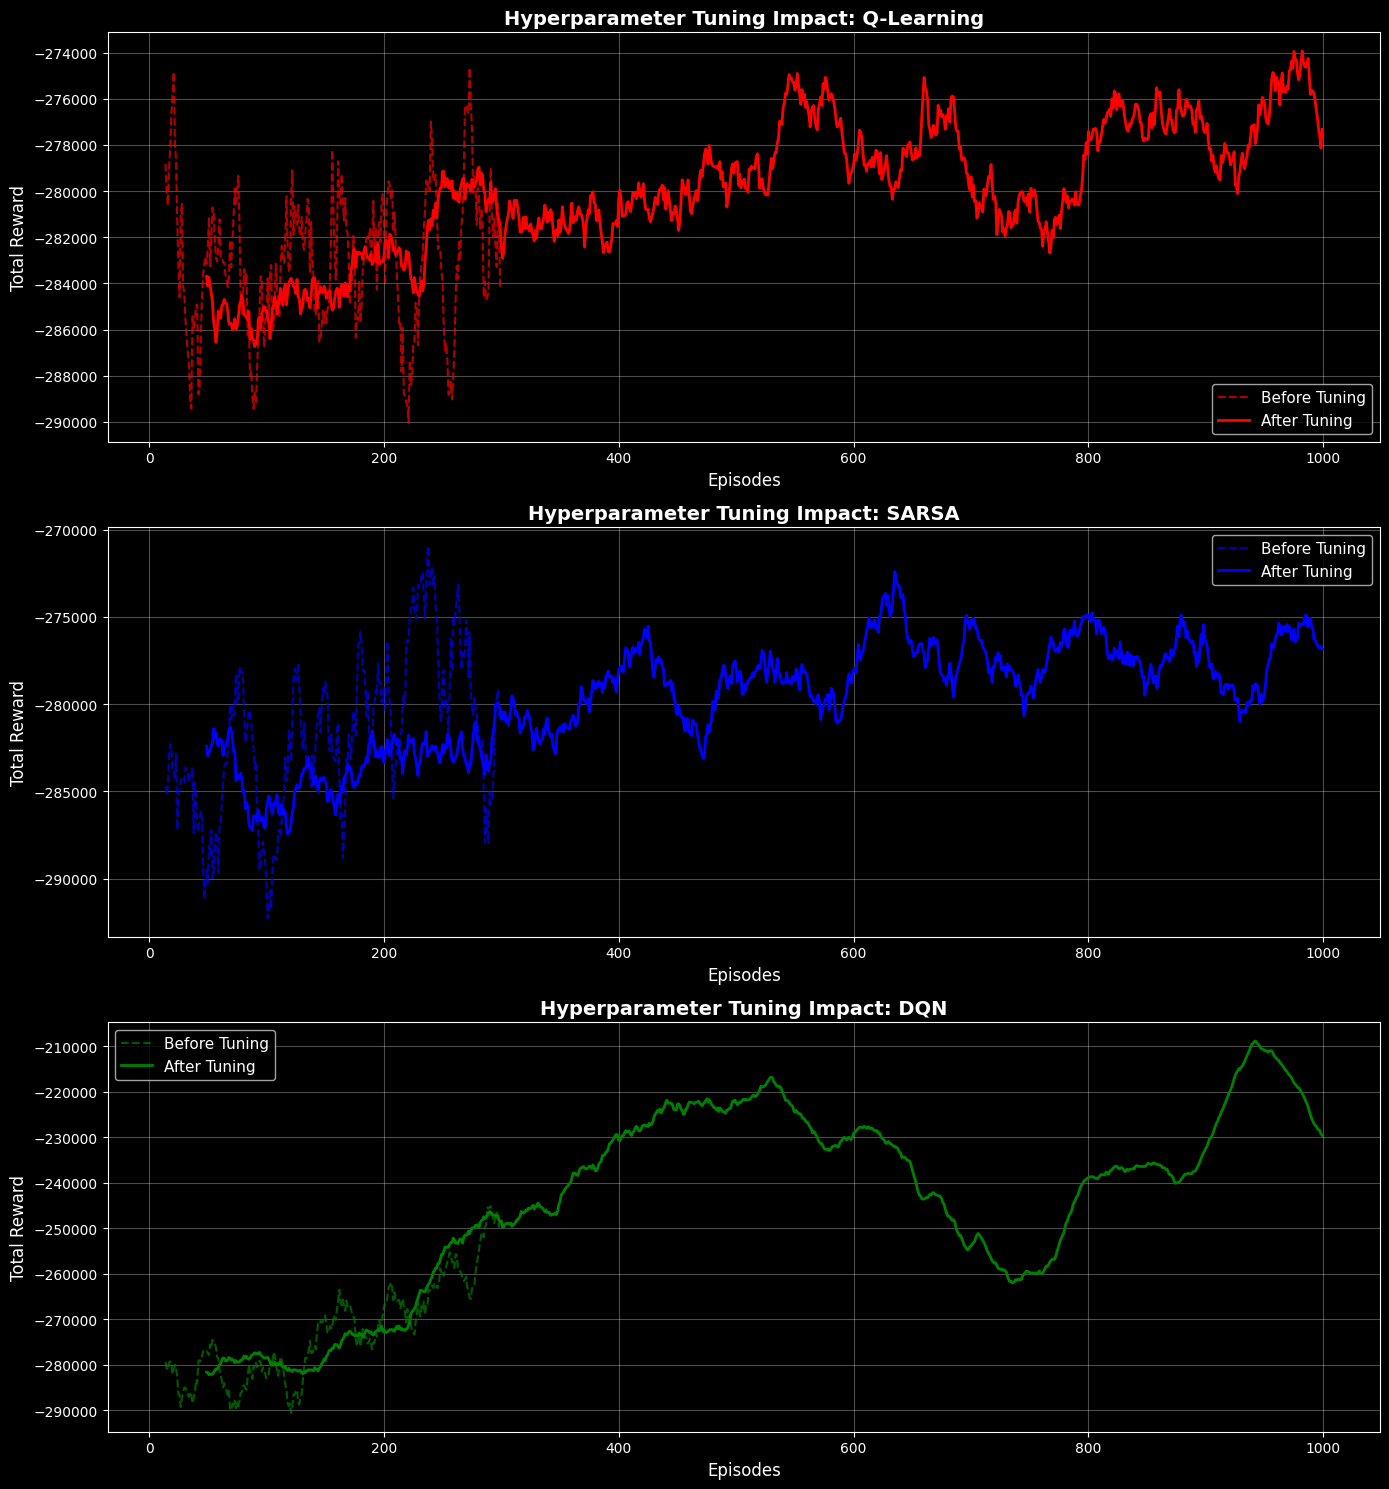

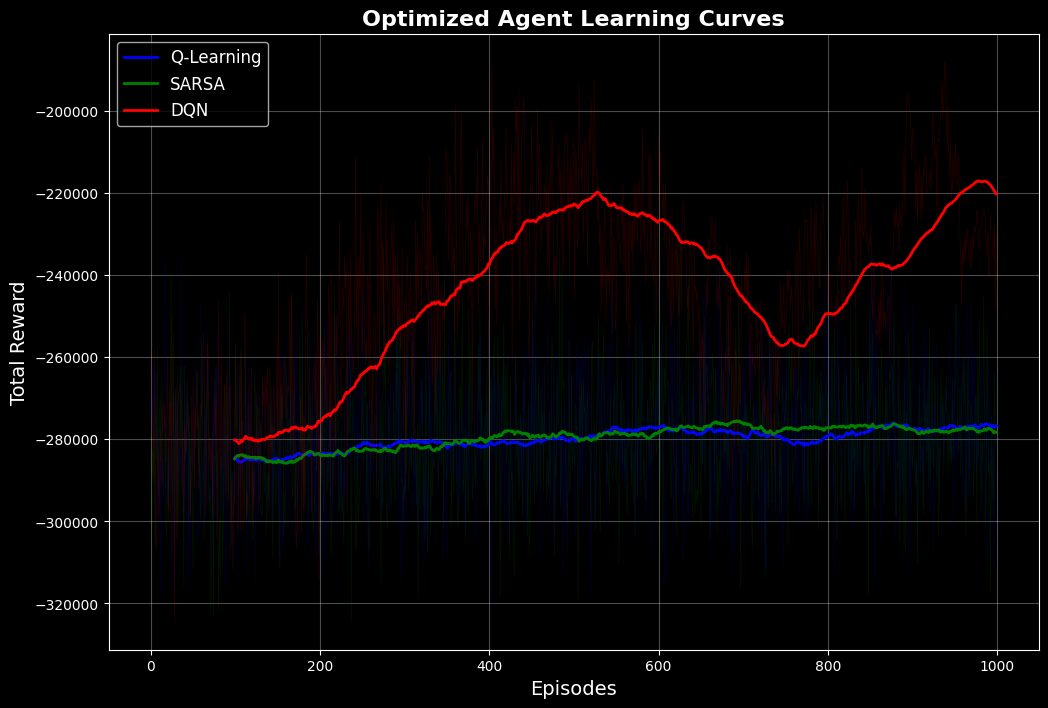

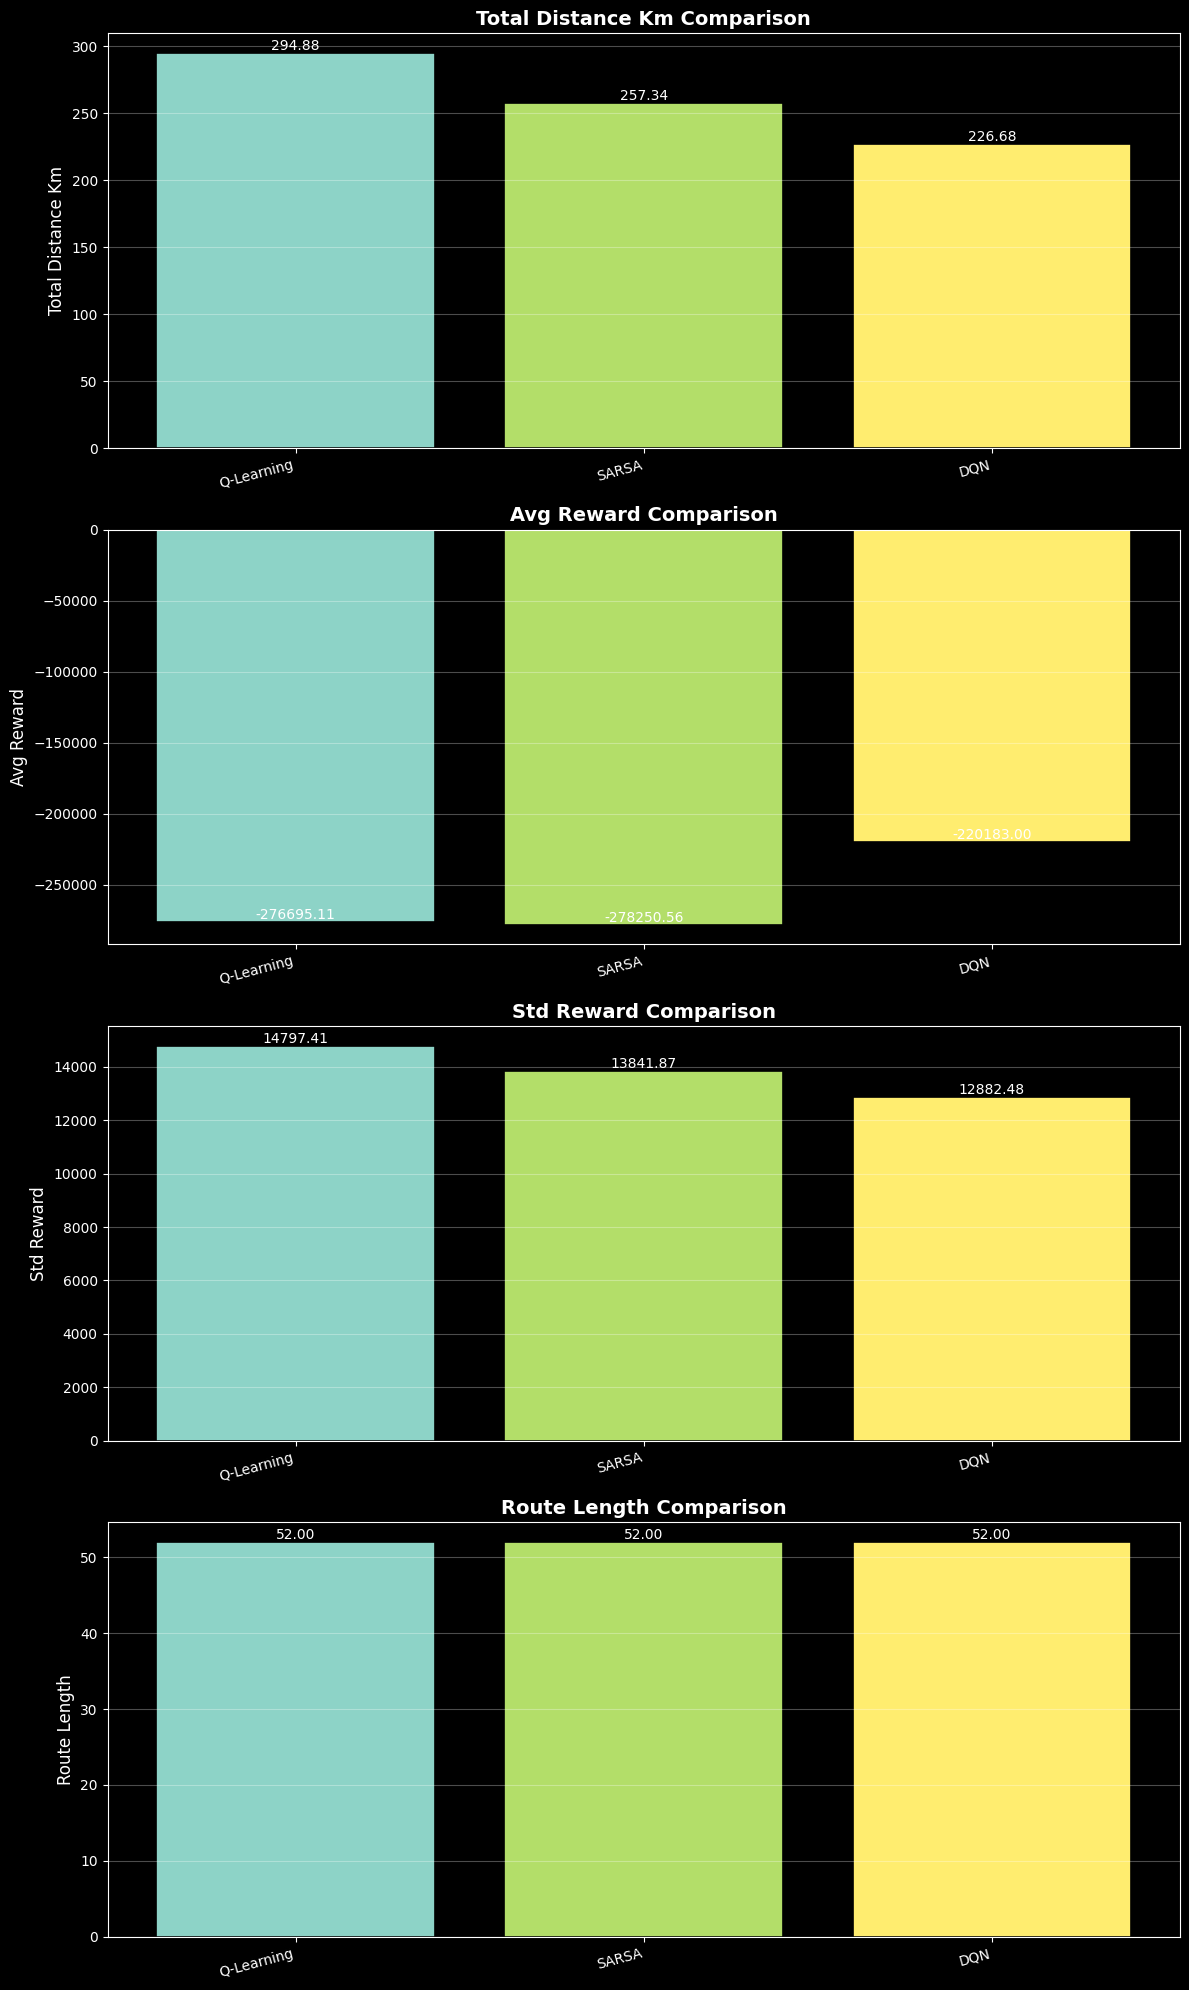


Performance Summary:
------------------------------------------------------------
Algorithm       Distance (km)   Avg Reward      Route Len 
------------------------------------------------------------
Q-Learning      294.88          -276695.11      52        
SARSA           257.34          -278250.56      52        
DQN             226.68          -220183.00      52        
------------------------------------------------------------


In [38]:
# --- 4. VISUALIZE TRAINING RESULTS ---
print("\n" + "=" * 50)
print("VISUALIZING TRAINING RESULTS")
print("=" * 50)

# 1. Plot tuning impact comparison
plot_tuning_impact(initial_reward_histories, optimized_reward_histories)

# 2. Plot final learning curves
plot_learning_curves(
    optimized_reward_histories,
    title="Optimized Agent Learning Curves"
)

# 3. Plot algorithm comparison
plot_comparison(final_results)

# 4. Create a summary table
print("\nPerformance Summary:")
print("-" * 60)
print(f"{'Algorithm':<15} {'Distance (km)':<15} {'Avg Reward':<15} {'Route Len':<10}")
print("-" * 60)
for name, results in final_results.items():
    print(f"{name:<15} {results['total_distance_km']:<15.2f} "
          f"{results['avg_reward']:<15.2f} {results['route_length']:<10}")
print("-" * 60)

In [39]:
# --- 5. FINAL AI ANALYSIS ---
if explainer.available:
    print("\n" + "=" * 50)
    print("FINAL AI-POWERED ANALYSIS")
    print("=" * 50)

    env_config = env.get_environment_summary()
    env_config["episodes"] = NUM_EPISODES_FINAL
    env_config["best_agent"] = best_route_info["agent"]
    env_config["best_distance_km"] = best_route_info["distance"]

    analysis = explainer.analyze_performance(final_results, env_config)
    display(Markdown(analysis))
else:
    print("\n" + "=" * 50)
    print("FINAL RESULTS (LOCAL ANALYSIS)")
    print("=" * 50)
    print(json.dumps(final_results, indent=2))


FINAL AI-POWERED ANALYSIS


Here's a comprehensive analysis of the delivery route optimization results:

## Analysis of Delivery Route Optimization Results

The environment configures a routing problem in Middlesbrough with 51 locations (including a depot) and a network-based distance metric. The goal is to find the shortest total distance for visiting all locations. Three Reinforcement Learning algorithms — Q-Learning, SARSA, and DQN — were trained for 1000 episodes, and their performance is evaluated based on total distance, average reward, and reward consistency (standard deviation).

### 1. PERFORMANCE SUMMARY

**The DQN algorithm unequivocally performed the best.**

*   **Total Distance:** DQN achieved a total route distance of **226.68 km**, which is the lowest among all algorithms. This is the most critical metric for delivery route optimization, as it directly impacts fuel costs, delivery times, and operational efficiency.
    *   SARSA: 257.34 km (13.5% longer than DQN)
    *   Q-Learning: 294.88 km (60.1% longer than DQN)
*   **Average Reward:** DQN also yielded the highest (least negative) average reward of **-220,182.99**. In RL, higher rewards indicate a policy that is better at achieving the objective (in this case, minimizing distance, which corresponds to minimizing negative reward). This aligns perfectly with its shortest route distance.
*   **Reward Standard Deviation:** DQN demonstrated the lowest standard deviation in reward (**12,882.48**). This suggests that DQN's learning process was more stable and converged to a more consistent policy compared to SARSA and Q-Learning, which exhibited higher variability.
*   **Route Length:** All algorithms successfully found routes that visited all 51 locations (resulting in a route length of 52 steps, implying depot -> 50 locations -> depot), indicating they completed the task. The differentiator is the quality of the path.

DQN's superior performance is expected in this scenario. With 51 locations, the state space for traditional tabular methods like Q-Learning and SARSA becomes astronomically large, making it difficult for them to learn effective policies within 1000 episodes. DQN, by utilizing a deep neural network to approximate the Q-function, can generalize across this vast state space much more effectively, leading to better and more stable optimal policies.

### 2. ALGORITHM COMPARISON: Trade-offs

| Feature / Algorithm | Q-Learning                      | SARSA                           | DQN                               |
| :------------------ | :------------------------------ | :------------------------------ | :-------------------------------- |
| **Policy Type**     | Off-Policy (learns Q*)          | On-Policy (learns Q for current policy) | Off-Policy (learns Q* using NN)   |
| **Performance (Dist)**| Worst (294.88 km)               | Mid (257.34 km)                 | Best (226.68 km)                  |
| **Avg Reward**      | Worst (-276K)                   | Mid (-278K, slightly worse than QL) | Best (-220K)                      |
| **Std Reward**      | Highest (14.8K)                 | Mid (13.8K)                     | Lowest (12.9K)                    |
| **Complexity**      | Simple, tabular                 | Simple, tabular                 | High (Deep Neural Network)        |
| **Sample Efficiency**| Low for large state space, struggled here | Low for large state space, struggled here | High (effective generalization for large spaces) |
| **Stability**       | Least stable (highest std dev)  | Moderate stability              | Most stable (lowest std dev)      |
| **Computation**     | Low                             | Low                             | High                              |
| **Generalization**  | Poor for large state spaces     | Poor for large state spaces     | Excellent for large state spaces  |

**Q-Learning vs. SARSA:**
*   **Performance:** SARSA performed better than Q-Learning in terms of total distance (257.34 km vs. 294.88 km) and had a slightly lower standard deviation of reward. This suggests that for this specific environment and limited training episodes, SARSA's on-policy learning, which considers the agent's actual next action when updating values, led to a more robust policy. Q-Learning's off-policy nature, which updates based on the greedy action, can sometimes be more optimistic and prone to exploring "cliffs" or highly suboptimal paths if exploration isn't managed well or if the environment is stochastic.
*   **Sample Efficiency & Stability:** Both are tabular methods and fundamentally struggle with the large state spaces inherent in routing problems with 51 locations. While SARSA showed marginal improvement, neither could efficiently explore or generalize enough within 1000 episodes to find a truly good solution.

**DQN vs. Tabular Methods (Q-Learning, SARSA):**
*   **Performance & Generalization:** DQN's ability to approximate the Q-function with a neural network is its core advantage. This allows it to generalize learned values across similar states, effectively handling the enormous state space where tabular methods fail. This explains its vastly superior route distance and higher average reward.
*   **Computational Cost & Complexity:** DQN comes with higher computational demands for training (GPU usage, more memory for experience replay) and increased complexity in hyperparameter tuning (network architecture, learning rates, replay buffer size, target network update frequency). In contrast, Q-Learning and SARSA are much simpler to implement and train on smaller problems.
*   **Sample Efficiency:** While deep RL methods are sometimes criticized for being less sample-efficient than tabular methods *in simple environments*, in complex environments like this one, their ability to generalize means they are *effectively* more sample-efficient in finding good policies with a reasonable number of interactions, as tabular methods would need an infeasible amount of data to cover the state space.
*   **Stability:** DQN's use of techniques like experience replay and a separate target network contributes significantly to its training stability, as evidenced by its lowest reward standard deviation. This prevents oscillating Q-values during learning.

### 3. BUSINESS IMPLICATIONS

The results carry significant implications for a real-world delivery business:

*   **Substantial Cost Savings:** The difference between DQN's 226.68 km and Q-Learning's 294.88 km is **68.2 km per route**. If a business runs hundreds or thousands of routes daily, this translates into massive savings on:
    *   **Fuel Costs:** Directly proportional to distance.
    *   **Vehicle Maintenance:** Reduced wear and tear, extending vehicle lifespan.
    *   **Driver Wages:** Shorter routes mean less driving time, potentially allowing drivers to complete more deliveries or finish shifts earlier.
*   **Increased Efficiency and Capacity:** Shorter routes free up driver and vehicle time, enabling more deliveries per day or better adherence to schedules. This directly increases the overall operational capacity of the delivery fleet.
*   **Improved Customer Satisfaction:** Faster and more predictable delivery times (due to optimized, consistent routes) lead to happier customers, which is crucial for repeat business and reputation.
*   **Environmental Benefits:** Reduced mileage translates to lower carbon emissions, aligning with corporate sustainability goals and potentially appealing to eco-conscious customers.
*   **Scalability for Complex Operations:** The success of DQN on 51 locations suggests its viability for even larger and more complex routing problems that real-world logistics often face, where traditional methods might be too slow or computationally intensive.

### 4. RECOMMENDATIONS

Based on this analysis, the recommendations are clear:

1.  **Deploy DQN:** The **DQN algorithm should be deployed** for real-world route optimization in this Middlesbrough delivery operation. Its superior performance in minimizing route distance, coupled with its stability and ability to handle large state spaces, makes it the optimal choice despite its higher initial computational cost and complexity. The significant operational savings and efficiencies it offers far outweigh these considerations.

2.  **Potential Improvements & Further Research:**
    *   **Hyperparameter Optimization:** Invest more time in fine-tuning DQN's hyperparameters (e.g., neural network architecture, learning rate, discount factor, exploration strategy, replay buffer size, target network update frequency). Even small improvements can yield significant cost savings over many routes.
    *   **Increase Training Episodes:** While 1000 episodes yielded good results for DQN, training for a longer duration (e.g., 5000-10000 episodes) might further refine the policy and discover even shorter routes, especially as the number of locations or complexity grows.
    *   **Advanced Deep RL Algorithms:** Explore other state-of-the-art Deep RL algorithms such as:
        *   **Policy Gradient Methods (e.g., PPO, A2C/A3C):** These directly learn a policy, which can be more stable and effective in environments with large discrete action spaces.
        *   **Graph Neural Networks (GNNs) with RL:** Given that routing problems are graph-based, combining GNNs for state representation with RL can be a powerful approach for scalability and performance.
        *   **Attention Mechanisms:** For even larger numbers of locations, attention mechanisms can help the agent focus on relevant parts of the graph.
    *   **Integrate Real-World Constraints:** Enhance the environment and reward function to reflect more realistic business constraints, such as:
        *   **Time Windows:** Specific delivery windows for certain locations.
        *   **Vehicle Capacity:** Weight or volume limits for packages.
        *   **Dynamic Traffic:** Incorporate real-time traffic data, requiring the agent to perform dynamic re-routing.
        *   **Multiple Vehicles:** Optimize routes for an entire fleet simultaneously.
        *   **Driver Breaks/Regulations:** Adherence to labor laws for drivers.
    *   **Benchmarking with Classical Solvers:** For static route optimization, compare DQN's performance against highly optimized classical algorithms (e.g., Concorde for TSP, Google OR-Tools for VRP) to understand how close the RL solution is to a theoretical optimum. This provides a valuable upper bound.

In conclusion, the successful deployment of DQN represents a significant leap in efficiency for delivery operations in Middlesbrough, demonstrating the tangible benefits of advanced reinforcement learning in logistics.

In [40]:
# --- 6. OPTIMIZED DELIVERY SEQUENCE ---
print("\n" + "=" * 50)
print("OPTIMIZED DELIVERY SEQUENCE")
print("=" * 50)

print(f"\nBest Algorithm: {best_route_info['agent']}")
print(f"Total Route Distance: {best_route_info['distance']:.2f} km")
print(f"Number of Stops: {len(best_route_info['route']) - 1}")

print("\nRoute Sequence:")
print("-" * 70)
print(f"{'Step':<6} {'Location Index':<16} {'Type':<12} {'Address'}")
print("-" * 70)

for step, loc_index in enumerate(best_route_info["route"]):
    address = env.addresses[loc_index] if loc_index < len(env.addresses) else f"Location {loc_index}"

    if step == 0:
        location_type = "DEPOT"
        icon = "🏠"
    elif step == len(best_route_info["route"]) - 1:
        location_type = "RETURN"
        icon = "🔙"
    else:
        location_type = "DELIVERY"
        icon = "📦"

    print(f"{step:<6} {loc_index:<16} {icon} {location_type:<11} {address}")

print("-" * 70)

# Calculate segment distances
print("\nRoute Segment Distances:")
print("-" * 40)
total_actual_distance = 0
for i in range(len(best_route_info["route"]) - 1):
    start_idx = best_route_info["route"][i]
    end_idx = best_route_info["route"][i + 1]
    segment_distance = env.distance_matrix[start_idx][end_idx] / 1000  # Convert to km
    total_actual_distance += segment_distance

    if i == 0:
        print(f"DEPOT → Stop {end_idx}: {segment_distance:.2f} km")
    elif i == len(best_route_info["route"]) - 2:
        print(f"Stop {start_idx} → DEPOT: {segment_distance:.2f} km")
    else:
        print(f"Stop {start_idx} → Stop {end_idx}: {segment_distance:.2f} km")

print("-" * 40)
print(f"Total Calculated Distance: {total_actual_distance:.2f} km")


OPTIMIZED DELIVERY SEQUENCE

Best Algorithm: DQN
Total Route Distance: 226.68 km
Number of Stops: 51

Route Sequence:
----------------------------------------------------------------------
Step   Location Index   Type         Address
----------------------------------------------------------------------
0      0                🏠 DEPOT       Location 0
1      26               📦 DELIVERY    Location 26
2      16               📦 DELIVERY    Location 16
3      9                📦 DELIVERY    Location 9
4      15               📦 DELIVERY    Location 15
5      38               📦 DELIVERY    Location 38
6      23               📦 DELIVERY    Location 23
7      41               📦 DELIVERY    Location 41
8      20               📦 DELIVERY    Location 20
9      48               📦 DELIVERY    Location 48
10     46               📦 DELIVERY    Location 46
11     44               📦 DELIVERY    Location 44
12     7                📦 DELIVERY    Location 7
13     4                📦 DELIVERY    Location 


ROUTE VISUALIZATION

1. Creating interactive route map...
Interactive route map saved to best_route_middlesbrough_interactive.html



2. Analyzing route progression...


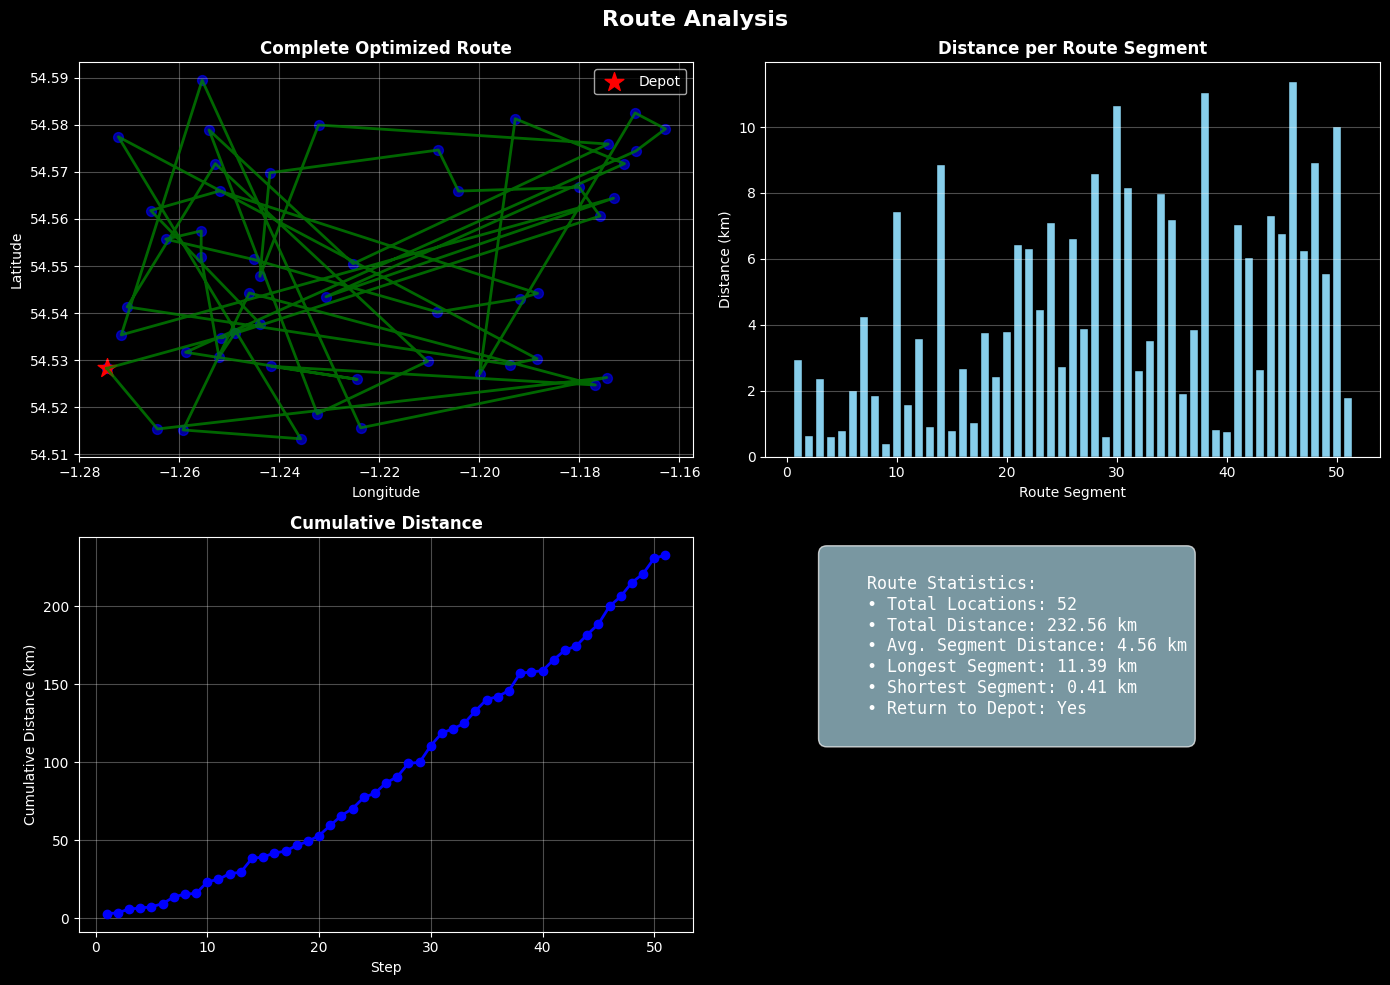


3. Generating network-based route visualization...
OSMnx route map saved to best_route_middlesbrough_network.png


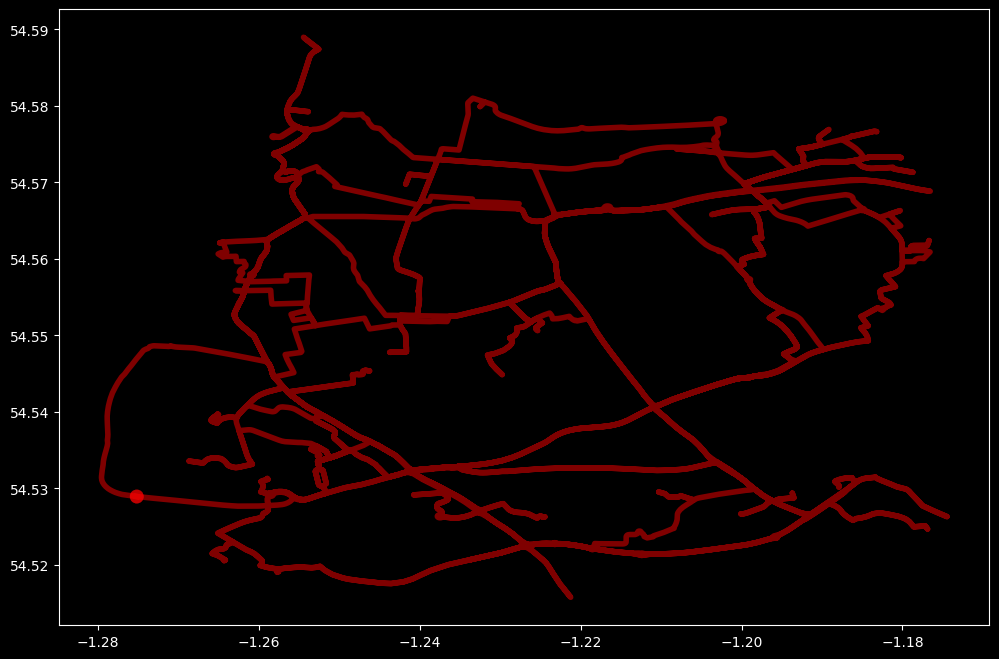

<Figure size 640x480 with 0 Axes>


VISUALIZATION COMPLETE

Generated files:
  • best_route_middlesbrough_interactive.html - Interactive map
  • learning_curves.png - Training progress
  • tuning_impact.png - Hyperparameter tuning effect
  • algorithm_comparison.png - Algorithm performance
  • route_progression.png - Route analysis
  • best_route_middlesbrough_network.png - Network route


In [41]:
# --- 7. ROUTE VISUALIZATION ---
print("\n" + "=" * 50)
print("ROUTE VISUALIZATION")
print("=" * 50)

# 1. Interactive Folium map
print("\n1. Creating interactive route map...")
folium_map = plot_delivery_route(
    locations=env.locations,
    route=best_route_info["route"],
    addresses=env.addresses,
    file_path=f"best_route_{CITY.lower()}_interactive.html"
)

# 2. Route progression analysis
print("\n2. Analyzing route progression...")
plot_route_progression(env.locations, best_route_info["route"])

# 3. OSMnx network-based route (if available)
if OSMNX_AVAILABLE and env.osmnx_client and DISTANCE_METRIC == 'network':
    print("\n3. Generating network-based route visualization...")
    try:
        best_route_nodes = [env.nodes[i] for i in best_route_info["route"]]
        plot_osmnx_route(
            env.osmnx_client.G,
            best_route_nodes,
            file_path=f"best_route_{CITY.lower()}_network.png"
        )
    except Exception as e:
        print(f"Could not generate network route: {e}")
else:
    print("\n3. Skipping network route (OSMnx not available or not using network distances)")

print("\n" + "=" * 50)
print("VISUALIZATION COMPLETE")
print("=" * 50)
print("\nGenerated files:")
print(f"  • best_route_{CITY.lower()}_interactive.html - Interactive map")
print(f"  • learning_curves.png - Training progress")
print(f"  • tuning_impact.png - Hyperparameter tuning effect")
print(f"  • algorithm_comparison.png - Algorithm performance")
print(f"  • route_progression.png - Route analysis")
if OSMNX_AVAILABLE:
    print(f"  • best_route_{CITY.lower()}_network.png - Network route")

In [45]:
# --- 8. EXPORT RESULTS ---
print("\n" + "=" * 50)
print("EXPORTING RESULTS")
print("=" * 50)

# Create summary dictionary
results_summary = {
    "city": CITY,
    "num_parcels": NUM_PARCELS,
    "distance_metric": DISTANCE_METRIC,
    "best_agent": best_route_info["agent"],
    "best_distance_km": best_route_info["distance"],
    "best_route": best_route_info["route"],
    "algorithm_performance": final_results,
    "locations": env.locations.tolist() if hasattr(env.locations, 'tolist') else env.locations,
    "addresses": env.addresses if hasattr(env, 'addresses') else []
}

# Save to JSON file
with open(f"delivery_results_{CITY.lower()}.json", "w") as f:
    json.dump(results_summary, f, indent=2)

print(f"Results saved to delivery_results_{CITY.lower()}.json")

# Create a markdown report
report_md = f"""
# Delivery Route Optimization Report

## Summary
- **City**: {CITY}
- **Parcels Delivered**: {NUM_PARCELS}
- **Best Algorithm**: {best_route_info['agent']}
- **Total Distance**: {best_route_info['distance']:.2f} km
- **Optimal Route**: {best_route_info['route']}

## Algorithm Performance
{' | '.join(['Algorithm', 'Distance (km)', 'Avg Reward', 'Route Length'])}
{' | '.join(['---', '---', '---', '---'])}

"""
for name, results in final_results.items():
    report_md += f"{name} | {results['total_distance_km']:.2f} | {results['avg_reward']:.2f} | {results['route_length']}\\n"

report_md += f"""

## Route Sequence"""


EXPORTING RESULTS


TypeError: Object of type int64 is not JSON serializable